In [1]:
import duckdb
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import requests
import mercury
sns.set_theme(palette="Set2")

In [21]:
# Merge parquet files
duckdb.execute("""
COPY (SELECT * FROM 'data/openalex/*.parquet') TO 'data/openalex/openalex.parquet' (FORMAT 'parquet');
""")

In [22]:
# Build dataframe
df = pd.read_parquet("data/openalex/openalex.parquet")
display(df.head(5))
print(df.shape)

,id,doi,year,type,type_crossref,institutions,countries,primary_location,is_oa,coverage.last_state,coverage.last_error,coverage.last_error_data
0,https://openalex.org/W3103145119,https://doi.org/10.1038/s41592-019-0686-2,2020,article,journal-article,"[Universidade Federal de Minas Gerais, Univers...","[FR, NL, AU, JP, RU, CA, FI, BR, GB, CZ, EE, US]",Nature Methods,True,IN_FOSM_FR,MISMATCH_TYPE,"('journal-article', 'article')"
1,https://openalex.org/W2970684805,https://doi.org/10.1136/bmj.l4898,2019,article,journal-article,"[Cochrane, Monash University, Inserm, Harvard–...","[FR, AU, CA, GB, DK, US]",BMJ,True,IN_FOSM_FR,MISMATCH_TYPE,"('journal-article', 'article')"
2,https://openalex.org/W2798336535,https://doi.org/10.1051/0004-6361/201833051,2018,article,journal-article,"[Laboratoire de Physique de l'ENS, Laboratoire...","[CN, RU, CU, AT, SE, FR, RS, IL, BR, ZA, MA, S...",Astronomy and Astrophysics,True,IN_FOSM_FR,MISMATCH_TYPE,"('journal-article', 'article')"
3,https://openalex.org/W2900756811,https://doi.org/10.1080/20013078.2018.1535750,2018,article,journal-article,"[Women & Infants Hospital of Rhode Island, Cas...","[TW, CN, GR, RU, MT, AT, NO, GM, IR, SI, SE, F...",Journal of extracellular vesicles,True,IN_FOSM_FR,MISMATCH_TYPE,"('journal-article', 'article')"
4,https://openalex.org/W2777074421,https://doi.org/10.1016/s1474-4422(17)30470-2,2018,article,journal-article,"[University of California, San Francisco, Medi...","[DE, AR, FR, ES, NL, AU, CA, JP, AT, CH, GB, D...",Lancet Neurology,True,IN_FOSM_FR,MISMATCH_TYPE,"('journal-article', 'article')"


(127073, 12)


# Sankey graph

In [23]:
# Build Sankey data
labels = ["OpenAlex", "UNDEFINED", "DOI_FOUND", "CRAWLED", "PARSED", "PARSED_FR", "IN_FOSM", "IN_FOSM_FR", 
          "BAD_DOI", "DOI_NO_ACCESS", "DOI_NO_CROSSREF", "DOI_NO_UNPAYWALL", "DOI_NO_PUBLICATION_YEAR",
          "DOI_EARLY_PUBLICATION_YEAR", "DOI_LATE_PUBLICATION_YEAR", "NOT_PARSED_FR", "NOT_PARSED", 
          "NOT_CRAWLED", "ALEX_DOI_NOT_FOUND", "ALEX_AUTHORSHIPS_NOT_FOUND", "ALEX_YEAR_NOT_FOUND", 
          "ALEX_TYPE_NOT_FOUND", "FOSM_YEAR_NOT_FOUND", "FOSM_TYPE_NOT_FOUND", "MISMATCH_YEAR", 
          "MISMATCH_TYPE", "MISMATCH_FRENCH_AFFILIATION", "OK"]
palette = ["#d9d9d9", "#d9d9d9", "#ccebc5", "#fb8072", "#bebada", "#ffffb3", "#8dd3c7", "#b3de69",
           "#bc80bd", "#bc80bd", "#bc80bd", "#bc80bd", "#bc80bd",
           "#bc80bd", "#bc80bd", "#bebada", "#fb8072",
           "#ccebc5", "#80b1d3", "#80b1d3", "#80b1d3",
           "#80b1d3", "#ffed6f", "#ffed6f", "#fdb462",
           "#fdb462", "#fdb462", "#b3de69"]
sources = []
targets = []
values = []
colors = []

In [24]:
# Correct journal-article / article error
df.loc[df["coverage.last_error_data"] == "('journal-article', 'article')", "coverage.last_error"] = "OK"
df.loc[df["coverage.last_error"] == "OK", "coverage.last_error_data"] = None

# Correct doi missing error
df.loc[df["doi"].isnull(), "coverage.last_state"] = "UNDEFINED"
df.loc[df["doi"].isnull(), "coverage.last_error"] = "ALEX_DOI_NOT_FOUND"

In [25]:
# Add publications states
states_dict = df["coverage.last_state"].value_counts().to_dict()
print(states_dict)
for key in states_dict:
    sources.append(labels.index("OpenAlex"))
    targets.append(labels.index(key))
    values.append(states_dict.get(key))
    colors.append(palette[labels.index(key)])

print(sources, targets, values)

{'IN_FOSM_FR': 80128, 'UNDEFINED': 31206, 'PARSED_FR': 7296, 'PARSED': 5024, 'DOI_FOUND': 3271, 'CRAWLED': 89, 'IN_FOSM': 59}
[0, 0, 0, 0, 0, 0, 0] [7, 1, 5, 4, 2, 3, 6] [80128, 31206, 7296, 5024, 3271, 89, 59]


In [26]:
# Add publications errors
grouped_df = df.groupby(by=["coverage.last_state", "coverage.last_error"], as_index=False).size()
display(grouped_df)
for index, row in grouped_df.iterrows():
    sources.append(labels.index(row["coverage.last_state"]))
    targets.append(labels.index(row["coverage.last_error"]))
    values.append(row["size"])
    colors.append(palette[labels.index(row["coverage.last_error"])])

print(sources, targets, values)

,coverage.last_state,coverage.last_error,size
0,CRAWLED,NOT_PARSED,89
1,DOI_FOUND,DOI_LATE_PUBLICATION_YEAR,2072
2,DOI_FOUND,DOI_NO_CROSSREF,285
3,DOI_FOUND,DOI_NO_PUBLICATION_YEAR,29
4,DOI_FOUND,DOI_NO_UNPAYWALL,4
5,DOI_FOUND,NOT_CRAWLED,881
6,IN_FOSM,MISMATCH_FRENCH_AFFILIATION,30
7,IN_FOSM,MISMATCH_TYPE,13
8,IN_FOSM,OK,16
9,IN_FOSM_FR,MISMATCH_TYPE,5916


[0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 2, 2, 6, 6, 6, 7, 7, 7, 4, 5, 1, 1] [7, 1, 5, 4, 2, 3, 6, 16, 14, 10, 12, 11, 17, 26, 25, 27, 25, 24, 27, 15, 27, 18, 9] [80128, 31206, 7296, 5024, 3271, 89, 59, 89, 2072, 285, 29, 4, 881, 30, 13, 16, 5916, 166, 74046, 5024, 7296, 30951, 255]


In [27]:
grouped_df = df.groupby(by=["coverage.last_error", "coverage.last_error_data"], as_index=False).size()
display(grouped_df)

,coverage.last_error,coverage.last_error_data,size
0,ALEX_DOI_NOT_FOUND,None,30951
1,DOI_LATE_PUBLICATION_YEAR,"('publication_year', 2022)",194
2,DOI_LATE_PUBLICATION_YEAR,"('publication_year', 2023)",1860
3,DOI_LATE_PUBLICATION_YEAR,"('publication_year', 2024)",18
4,DOI_NO_ACCESS,"('doi_status_code', 404)",241
...,...,...,...
72,MISMATCH_YEAR,"(2022, 2023)",26
73,MISMATCH_YEAR,"(2023, 2022)",1
74,NOT_CRAWLED,None,881
75,NOT_PARSED,None,89


In [28]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      hovertemplate = "%{label}<br > %{value} publications<extra></extra>",
      color = "blue"
    ),
    link = dict(
      source = sources,
      target = targets,
      value = values,
      color = colors
  ))])

fig.update_layout(title_text="OpenAlex french publications coverage", font_size=10)
fig.show()

# Exploratory data analysis

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127073 entries, 0 to 127072
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   id                        127073 non-null  object
 1   doi                       96122 non-null   object
 2   year                      127073 non-null  int64 
 3   type                      127073 non-null  object
 4   type_crossref             127073 non-null  object
 5   institutions              127073 non-null  object
 6   countries                 127073 non-null  object
 7   primary_location          118583 non-null  object
 8   is_oa                     127073 non-null  bool  
 9   coverage.last_state       127073 non-null  object
 10  coverage.last_error       127073 non-null  object
 11  coverage.last_error_data  45715 non-null   object
dtypes: bool(1), int64(1), object(10)
memory usage: 10.8+ MB


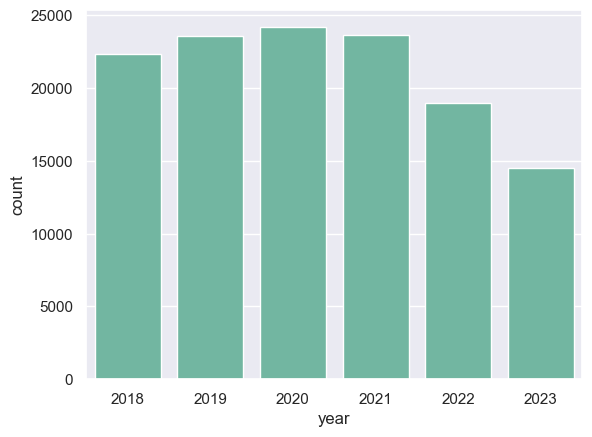

In [11]:
# Plot years
sns.countplot(df, x="year")
plt.show()

<Axes: ylabel='coverage.last_state'>

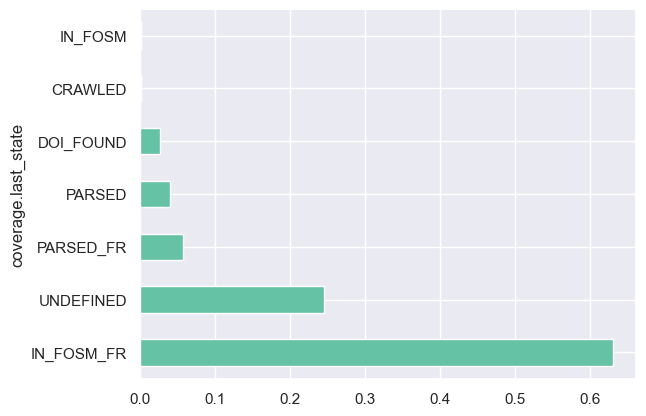

In [32]:
# Plot states
df["coverage.last_state"].value_counts(normalize=True).plot(kind="barh")

# French affiliations analysis

In [12]:
bad_affiliations_df = df[df["coverage.last_error"] == "MISMATCH_FRENCH_AFFILIATION"].copy().reset_index()
display(bad_affiliations_df[["id", "doi", "coverage.last_error_data"]])
bad_affiliations = bad_affiliations_df["coverage.last_error_data"].to_list()

,id,doi,coverage.last_error_data
0,https://openalex.org/W2805870922,https://doi.org/10.1681/asn.2017121260,"['Division of Nephrology and Hypertension, Cen..."
1,https://openalex.org/W2889373178,https://doi.org/10.1039/c8nr05787g,['1015 Lausanne; EPFL; Laboratoire des Matéria...
2,https://openalex.org/W2887463283,https://doi.org/10.12688/f1000research.14417.1,"['Clinique du Vertige, Centre Hospitalier Emil..."
3,https://openalex.org/W4225140177,https://doi.org/10.1038/s41467-022-29959-1,"['Department of Sciences and Engineering, Sorb..."
4,https://openalex.org/W3080555168,https://doi.org/10.1145/3407023.3409219,['Montimage']
5,https://openalex.org/W4223896490,https://doi.org/10.1007/s00500-022-07068-x,"['Sorbonne Center of Artificial Intelligence, ..."
6,https://openalex.org/W4224233561,https://doi.org/10.1002/anie.202203938,['Department of Sciences and Engineering Sorbo...
7,https://openalex.org/W3101925414,https://doi.org/10.1039/c9na00323a,['Foundation of Research and Technology-Hellas...
8,https://openalex.org/W2992815577,https://doi.org/10.1039/c9nr08453c,['EPFL; Faculty of Engineering; Institute of M...
9,https://openalex.org/W4226275118,https://doi.org/10.1021/acs.cgd.2c00225,"['Department of Sciences and Engineering, Sorb..."


In [13]:
def clean_affiliations(affiliation):
    return affiliation.removeprefix("['").removesuffix("']").split("', '")

In [14]:
cleaned_affiliations = list(set(sum([clean_affiliations(affiliation) for affiliation in bad_affiliations], [])))
cleaned_affiliations

['Department of Sciences and Engineering Sorbonne University Abu Dhabi  38044 Abu Dhabi United Arab Emirates; Smart Materials Lab New York University Abu Dhabi  129188 Abu Dhabi United Arab Emirates',
 'Department of Sciences and Engineering, Sorbonne University Abu Dhabi, Abu Dhabi, United Arab Emirates',
 'Department of Sciences and Engineering, Sorbonne University Abu Dhabi, Abu Dhabi, UAE; Smart Materials Lab, New York University Abu Dhabi, Abu Dhabi, UAE',
 'Présidente de la SFP.',
 '1015 Lausanne; EPFL; Laboratoire des Matériaux Semiconducteurs; Switzerland; École Polytechnique Fédérale de Lausanne',
 'Division of Nephrology and Hypertension, Center for Translational Metabolism and Health, Institute for Public Health and Medicine, Northwestern University Feinberg School of Medicine, Chicago, Illinois;; Renal Division and',
 'Sorbonne Center of Artificial Intelligence, Sorbonne University-Abu Dhabi, Abu Dhabi, United Arab Emirates',
 'Department of Sciences and Engineering, Sorbon

In [15]:
bad_institutions = ["Sorbonne University", "EPFL", "Pondicherry Institute of Medical Sciences",
                    "CRMEF", "Université de Sfax", "Renal Division and", "Institut Pasteur", "SFP", 
                    "Hôpital Ambroise-Paré, Boulogne-Billancourt", "Dipartimento di Scienze e Tecnologie Chimiche",
                    "Centre Hospitalier Emile Mayrisch", "Montimage"]

def apply_bad_institutions(affiliation_string):
    for institution in bad_institutions:
        if institution in affiliation_string:
            return institution
    return "Other"

bad_affiliations_df["bad_institutions"] = bad_affiliations_df["coverage.last_error_data"].apply(apply_bad_institutions)

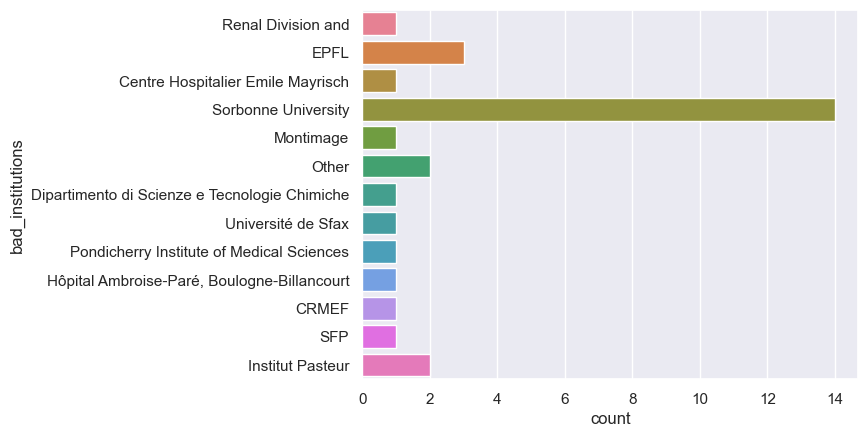

In [16]:
sns.countplot(bad_affiliations_df, y="bad_institutions", hue="bad_institutions")
plt.show()

In [17]:
bad_affiliations_df[bad_affiliations_df["bad_institutions"] == "Other"]

,index,id,doi,year,type,type_crossref,institutions,countries,primary_location,is_oa,coverage.last_state,coverage.last_error,coverage.last_error_data,bad_institutions
7,25604,https://openalex.org/W3101925414,https://doi.org/10.1039/c9na00323a,2019,article,journal-article,[Foundation for Research and Technology Hellas...,"[DE, FR, GR]",Nanoscale advances,True,IN_FOSM,MISMATCH_FRENCH_AFFILIATION,['Foundation of Research and Technology-Hellas...,Other
12,30139,https://openalex.org/W2893387639,https://doi.org/10.1109/icton.2018.8473898,2018,article,proceedings-article,[Centre Tecnologic De Telecomunicacions De Cat...,"[FR, ES]",None,True,IN_FOSM,MISMATCH_FRENCH_AFFILIATION,['[ATOS]'],Other


# Various analysis

In [18]:
df[(df["coverage.last_state"] == "IN_FOSM") & (df["coverage.last_error"] == "OK")].iloc[14]

id                                           https://openalex.org/W4205284904
doi                               https://doi.org/10.1007/978-3-030-92684-7_8
year                                                                     2021
type                                                             book-chapter
type_crossref                                                    book-chapter
institutions                [EURECOM, Ikerlan, Construcciones y Auxiliar d...
countries                                                        [FR, ES, DE]
primary_location                            Lecture Notes in Computer Science
is_oa                                                                   False
coverage.last_state                                                   IN_FOSM
coverage.last_error                                                        OK
coverage.last_error_data                                                 None
Name: 87105, dtype: object

In [19]:
id = "W2924329629"
response = requests.get(f"https://api.openalex.org/works/{id}").json()
mercury.JSON(response)

In [20]:
with open(f"data/openalex/part_018.jsonl") as f:
    total = 0
    total_fr = 0
    for line in f:
        total +=1
        publication = json.loads(line)
        publication_year = publication.get("publication_year")
        if publication_year is None or publication_year < 2018 or publication_year > 2023:
            continue
        is_paratext = publication.get("is_paratext")
        if is_paratext:
            continue
        if "authorships" in publication:
                countries = []
                for authorship in publication.get("authorships"):
                    countries += authorship.get("countries")
                if "FR" in countries:
                    total_fr +=1

FileNotFoundError: [Errno 2] No such file or directory: 'data/openalex/part_018.jsonl'

In [ ]:
test = pd.read_json("data/openalex/openalex_2021_2021.json")

In [ ]:
test_ids = test["id"].to_list()